In [5]:
import os
import random
import math
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import xml.etree.ElementTree as ET
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from tqdm import tqdm

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
images_path = Path('/home/jovyan/Users/natashalove/Dropbox/CV_training_resources/labels_all/images')
anno_path = Path('/home/jovyan/Users/natashalove/Dropbox/CV_training_resources/labels_all/labels')

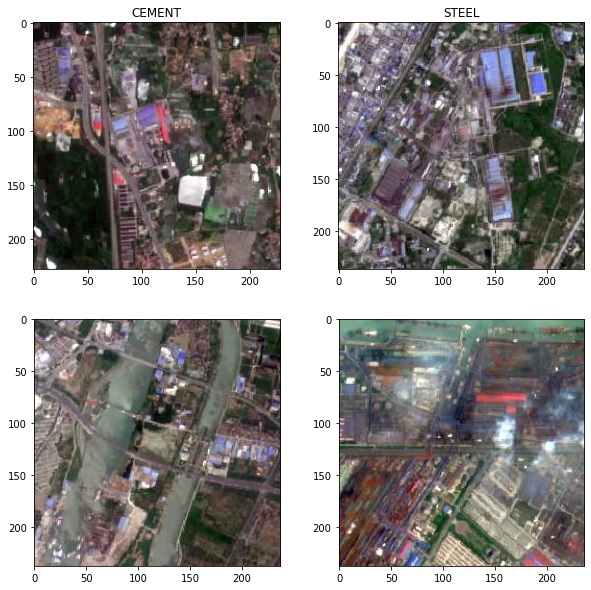

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import boto3
import tempfile

s3 = boto3.resource('s3')
bucket = s3.Bucket('sfi-shared-assets')
object = bucket.Object('CHN_scenes_all/cement_china/cement_0003.png')
tmp = tempfile.NamedTemporaryFile()
with open(tmp.name, 'wb') as f:
    object.download_fileobj(f)
    img1 = mpimg.imread(tmp.name)
    

s3 = boto3.resource('s3')
bucket = s3.Bucket('sfi-shared-assets')
object = bucket.Object('CHN_scenes_all/cement_china/cement_0006.png')
tmp = tempfile.NamedTemporaryFile()
with open(tmp.name, 'wb') as f:
    object.download_fileobj(f)
    img2 = mpimg.imread(tmp.name)
    
s3 = boto3.resource('s3')
bucket = s3.Bucket('sfi-shared-assets')
object = bucket.Object('CHN_scenes_all/steel_china/steel_0112.png')
tmp = tempfile.NamedTemporaryFile()
with open(tmp.name, 'wb') as f:
    object.download_fileobj(f)
    img3 = mpimg.imread(tmp.name)
    
s3 = boto3.resource('s3')
bucket = s3.Bucket('sfi-shared-assets')
object = bucket.Object('CHN_scenes_all/steel_china/steel_0118.png')
tmp = tempfile.NamedTemporaryFile()
with open(tmp.name, 'wb') as f:
    object.download_fileobj(f)
    img4 = mpimg.imread(tmp.name)


fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img1)
ax1.set_title('CEMENT')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img3)
ax2.set_title('STEEL')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(img2)
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img4)


In [8]:
def filelist(anno_path, extension):
    l = []
    for root, dirs, files in os.walk(anno_path):
        for file in files:
            if file.endswith(extension) and not file.startswith('.'):
                 l.append(os.path.join(root, file))

    return l

In [9]:
def generate_train_df(anno_path='/home/jovyan/Users/natashalove/Dropbox/CV_training_resources/labels_all/labels'):
    annotations = filelist(anno_path, '.xml')
    anno_list = []

    for anno_path in tqdm(annotations):        
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/' + root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(float(root.find("./object/bndbox/xmin").text))
        anno['ymin'] = int(float(root.find("./object/bndbox/ymin").text))
        anno['xmax'] = int(float(root.find("./object/bndbox/xmax").text))
        anno['ymax'] = int(float(root.find("./object/bndbox/ymax").text))
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [10]:
df_train = generate_train_df(anno_path)

100%|██████████| 49604/49604 [03:41<00:00, 224.41it/s]


In [11]:
print(df_train.shape)
df_train.head()

(49604, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,/home/jovyan/Users/natashalove/Dropbox/CV_trai...,256,256,2,0,176,71,256
1,/home/jovyan/Users/natashalove/Dropbox/CV_trai...,256,256,1,46,2,256,248
2,/home/jovyan/Users/natashalove/Dropbox/CV_trai...,256,256,2,180,19,256,217
3,/home/jovyan/Users/natashalove/Dropbox/CV_trai...,256,256,1,23,0,256,103
4,/home/jovyan/Users/natashalove/Dropbox/CV_trai...,256,256,2,50,0,256,135


In [12]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, x):
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    cols, rows = np.nonzero(Y)
    if len(cols) == 0:
        return np.zeros(4, dtype = np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype = np.float32)

def create_bb_array(x):
    return np.array([x[5], x[4], x[7], x[6]])

def resize_image_bb(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [13]:
new_paths = []
new_bbs = []
train_path_resized = Path('/home/jovyan/Users/natashalove/Dropbox/CV_training_resources/labels_all/resized')

for index, row in tqdm(df_train.iterrows()):
    new_path, new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values), 256)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

49604it [55:28, 14.90it/s]


In [14]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

(256, 256, 3)


In [15]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([  0.,  43.,  87., 255.], dtype=float32)

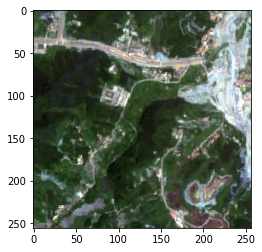

In [16]:
plt.imshow(im)

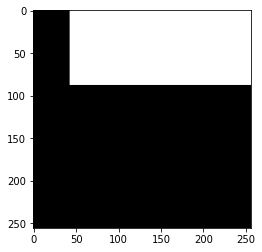

In [17]:
plt.imshow(Y, cmap='gray')

In [18]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color, fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

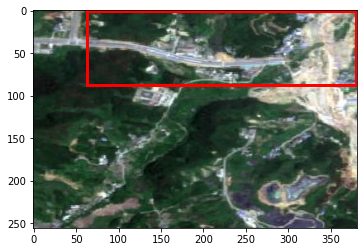

In [21]:
# stretched

im = cv2.imread(str(df_train.values[58][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[58][9])